In [3]:
%load_ext autoreload
%autoreload 2
%load_ext ipython_memory_usage

Enabling IPython Memory Usage, use %imu_start to begin, %imu_stop to end


In [20]:
from neuralop.training.callbacks import BasicLoggerCallback,  Callback
import matplotlib.pyplot as plt

class DisplayCallback(Callback):
    def __init__(self, model, x, y):
        super().__init__()
        self.x = x
        self.y = y.detach().numpy()
        self.model = model
    
    def on_epoch_end(self, epoch, train_err, avg_loss):
        out = self.model(self.x).detach().numpy()
        plt.imshow(out[0,0])
        plt.colorbar()
        plt.show()

        plt.imshow(self.y[0,0])
        plt.colorbar()
        plt.show()

In [20] used 0.0 MiB RAM in 0.10s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 1439.7 MiB


In [30]:
import torch
import sys
import time
import wandb
from MachineLearning.pytorch_dataset import get_pytorch_dataloader

from neuralop.models import FNO2d, UNO
from neuralop import Trainer
from neuralop import LpLoss, H1Loss
import torch.nn.functional as F

def train_fno(model_name, data_folder, model_config, training_config):

    #model = UNO(1,1, hidden_channels=32, projection_channels=32, uno_out_channels = [8,16,16,16,8], \
            #uno_n_modes= [[8,8],[4,4],[2,2],[4,4],[8,8]], uno_scalings=  [[0.5,0.5],[0.5,0.5],[1,1],[2,2],[2,2]],\
            #horizontal_skips_map = None, n_layers = 5, domain_padding = 0.2)

    model = FNO2d(16, 16, in_channels=1, hidden_channels=32, projection_channels=64, factorization='tucker', rank=0.42)
    unique_model_name = '{}_{}'.format(model_name, str(time.time()))
    local_save_path = 'models/{}.keras'.format(unique_model_name)

    # Start a run, tracking hyperparameters
    wandb.init(
        # set the wandb project where this run will be logged
        project="EMPIRIC2-AI-emulator",

        # track hyperparameters and run metadata with wandb.config
        config=training_config
    )

    ## track the model with an artifact
    model_artifact = wandb.Artifact(
        unique_model_name,
        type="model",
        metadata={
            "save_path": local_save_path,
            "model_config": model_config,
            "param_count": None
        }
    )

    wandb.run.log_artifact(model_artifact)

    # [optional] use wandb.config as your config
    config = wandb.config

    ## track the dataset used with an artifact
    data_artifact = wandb.Artifact(
        "processed_data",
        type="dataset",
        metadata={
            "source": "local dataset",
            "data_folder": data_folder,
            "batch_size": config.batch_size,
            "input_description": "[-1, 1] normalized 'genesis_grids'",
            "output_description": "Mean Tropical Cyclone counts over 10 years"
        }
    )


    ## save the train file and unet file so that we can load the model later
    wandb.run.log_code(".", include_fn=lambda p, r: p.endswith("train.py") or p.endswith("unet.py"))

    train_data = get_pytorch_dataloader(data_folder, batch_size=config.batch_size, n_samples=32)
    test_data = get_pytorch_dataloader(data_folder, dataset="test", batch_size=config.batch_size, n_samples=1)
    one_sample = next(iter(train_data))
    
    device = 'cpu'
    # %%
    # Create the optimizer
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=3e-3,
                                 )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

    # %%
    # Creating the losses
    l2loss = LpLoss(d=2, p=2)
    h1loss = H1Loss(d=2)

    train_loss = l2loss
    eval_losses = {'h1': h1loss, 'l2': l2loss}

    # %%

    print('\n### MODEL ###\n', model)
    print('\n### OPTIMIZER ###\n', optimizer)
    print('\n### SCHEDULER ###\n', scheduler)
    print('\n### LOSSES ###')
    print(f'\n * Train: {train_loss}')
    print(f'\n * Test: {eval_losses}')
    sys.stdout.flush()

    # %%
    # Create the trainer
    trainer = Trainer(model=model, n_epochs=30,
                      device=device,
                      wandb_log=True,
                      log_test_interval=1,
                      use_distributed=False,
                      log_output=True,
                      verbose=True,
                      callbacks=[BasicLoggerCallback(),  DisplayCallback(model, one_sample['x'], one_sample['y'])]
                      )

    # %%
    # Actually train the model on our small Darcy-Flow dataset

    trainer.train(train_loader=train_data,
                  test_loaders={32: test_data},
                  optimizer=optimizer,
                  scheduler=scheduler,
                  regularizer=False,
                  training_loss=train_loss,
                  eval_losses=eval_losses)

    torch.save(model.state_dict(), local_save_path)

TRAINING_CONFIG = {
            "Name": "one-batch",
            "optimizer": "adam",
            "loss": "mean_squared_error",
            "metric": "mean_absolute_error",
            "learning_rate": 0.003,
            "epoch": 40,
            "batch_size": 32
        }

MODEL_CONFIG = {
    "genesis_size": (112, 224, 1),
    "output_size": (110, 210, 1),
    "kernel_size": (5,5),
    "dropout": False,
    "batch_norm": True,
    "down_filters": [8, 16, 32],
    "up_filters": [32, 16, 8]
}

In [30] used 0.1 MiB RAM in 0.11s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 1440.2 MiB


wandb: WARNING No relevant files were detected in the specified directory. No code will be logged to your run.



### MODEL ###
 FNO2d(
  (fno_blocks): FNOBlocks(
    (convs): SpectralConv(
      (weight): ModuleList(
        (0-3): 4 x ComplexTuckerTensor(shape=(64, 64, 16, 9), rank=(51, 51, 13, 7))
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (lifting): MLP(
    (fcs): ModuleList(
      (0): Conv2d(1, 256, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (projection): MLP(
    (fcs): ModuleList(
      (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
    )
  )
)

### OPTIMIZER ###
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.003
    lr: 0.003
    maximize: False
    weight_decay: 0
)

### SCHEDULER ###

### LOSSES ###

 * Train: <neuralop.losses.da

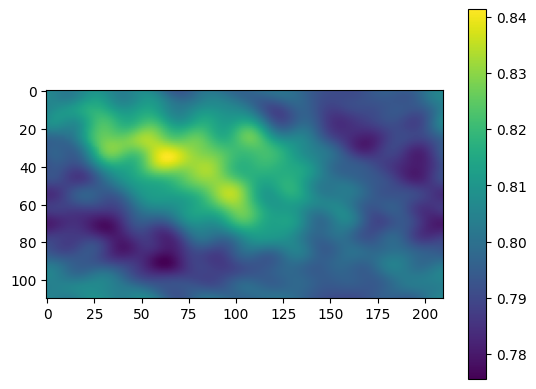

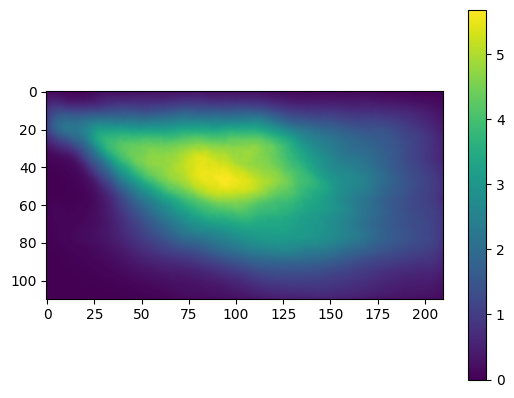

[1] time=14.11, avg_loss=0.8172, train_err=24.5162, 32_h1=9.2179, 32_l2=12.7955


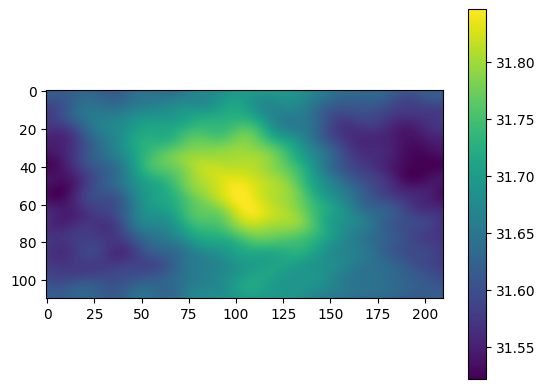

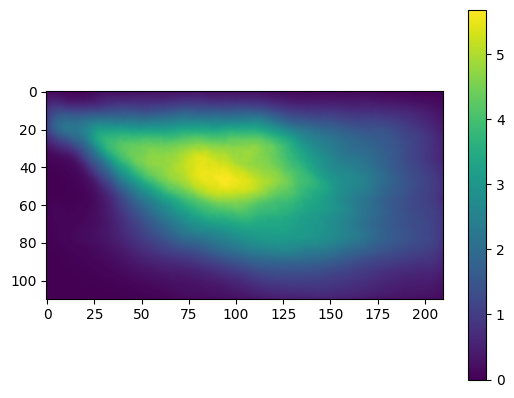

[2] time=13.91, avg_loss=13.5450, train_err=406.3499, 32_h1=0.8380, 32_l2=0.6762


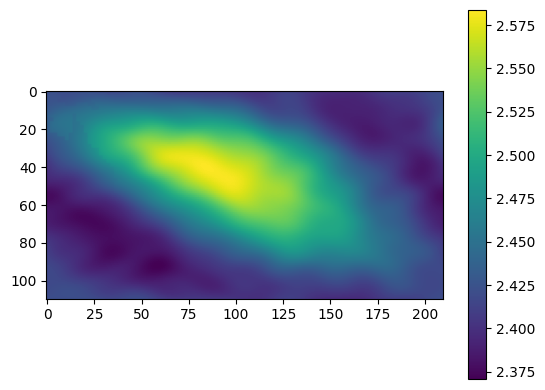

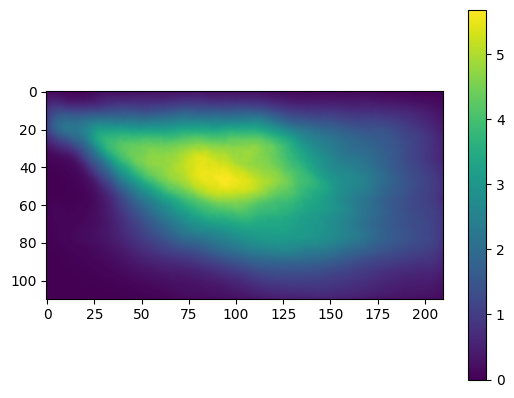

[3] time=13.85, avg_loss=0.7180, train_err=21.5412, 32_h1=0.9395, 32_l2=0.8894


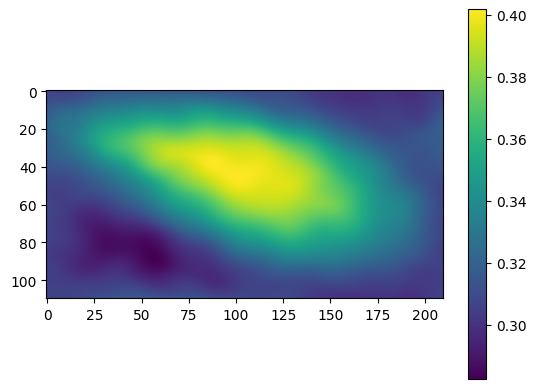

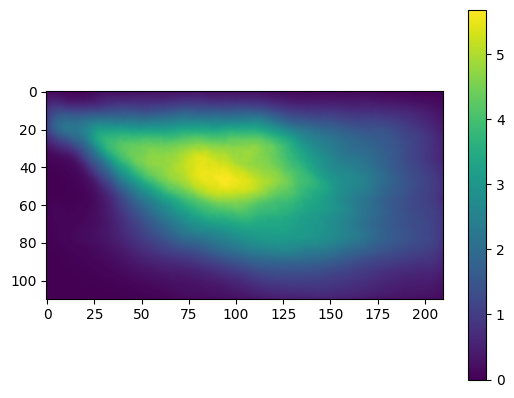

[4] time=13.88, avg_loss=0.9489, train_err=28.4663, 32_h1=0.9651, 32_l2=0.9386


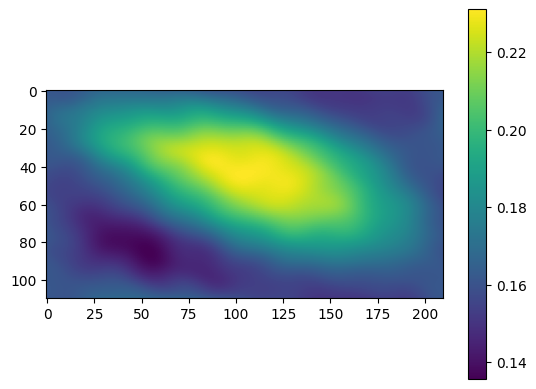

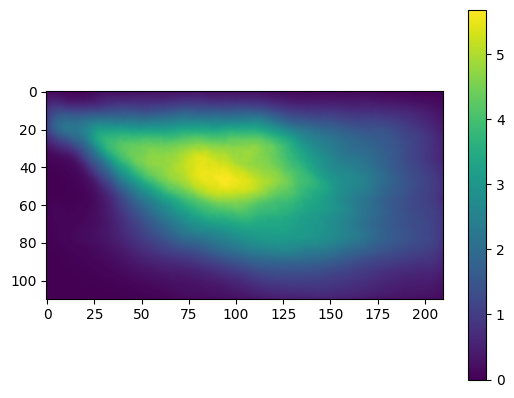

[5] time=14.03, avg_loss=1.0013, train_err=30.0376, 32_h1=0.9693, 32_l2=0.9469


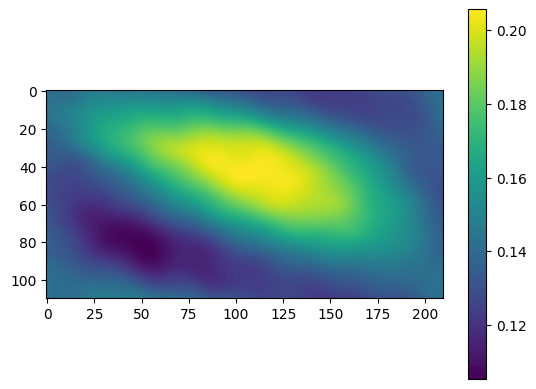

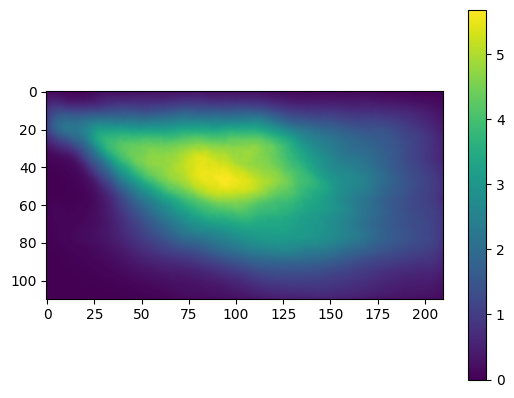

[6] time=13.87, avg_loss=1.0101, train_err=30.3027, 32_h1=0.9682, 32_l2=0.9456


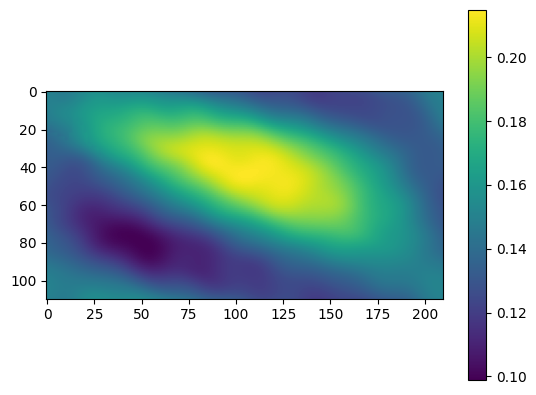

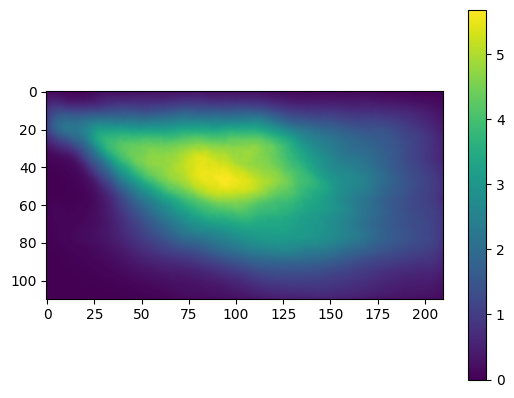

[7] time=14.06, avg_loss=1.0087, train_err=30.2604, 32_h1=0.9644, 32_l2=0.9392


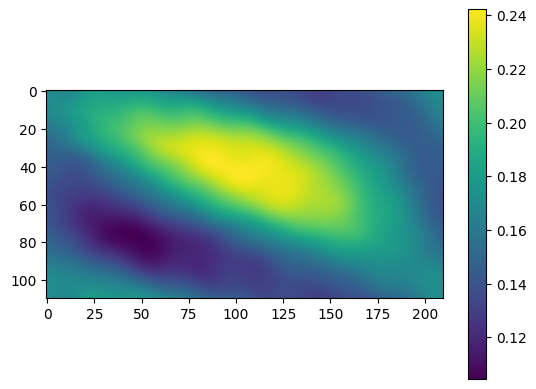

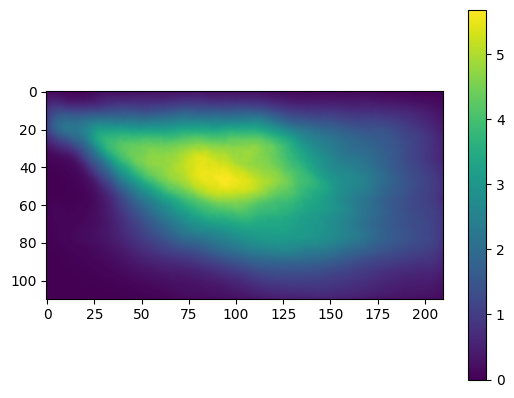

[8] time=14.01, avg_loss=1.0018, train_err=30.0540, 32_h1=0.9567, 32_l2=0.9256


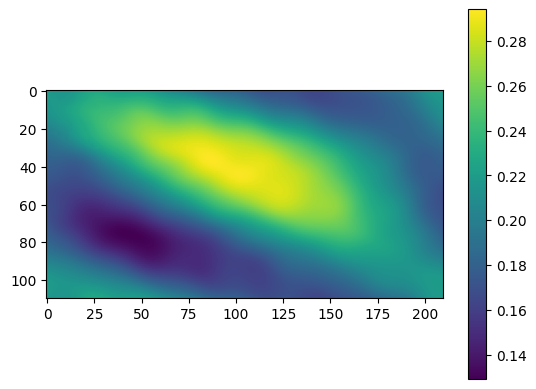

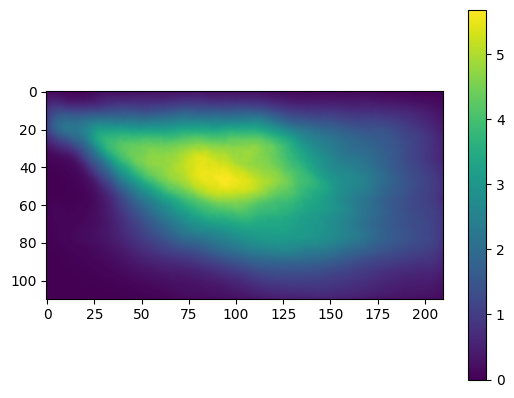

[9] time=14.01, avg_loss=0.9874, train_err=29.6215, 32_h1=0.9443, 32_l2=0.9027


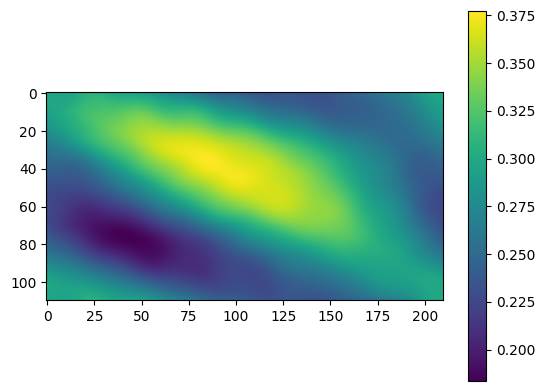

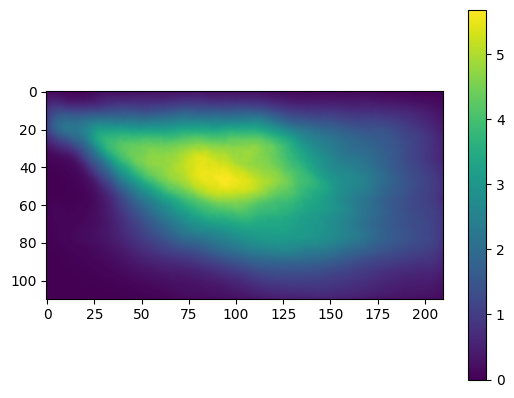

[10] time=13.94, avg_loss=0.9629, train_err=28.8866, 32_h1=0.9278, 32_l2=0.8709


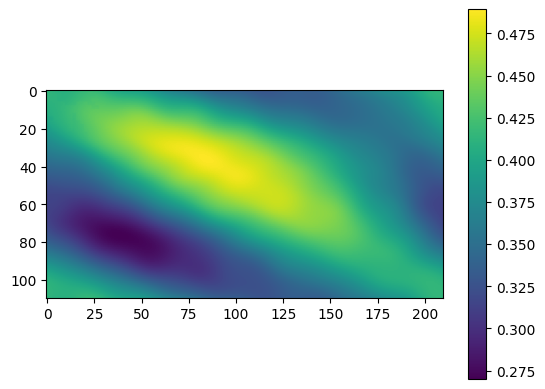

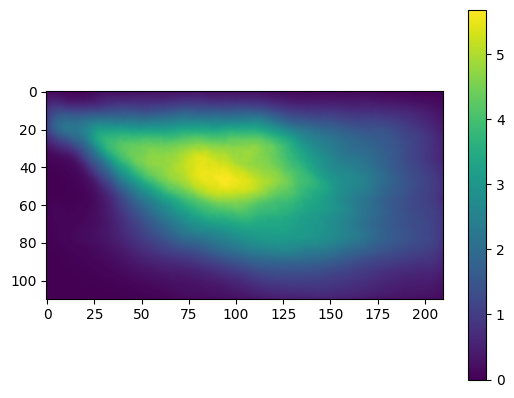

[11] time=14.06, avg_loss=0.9290, train_err=27.8710, 32_h1=0.9081, 32_l2=0.8317


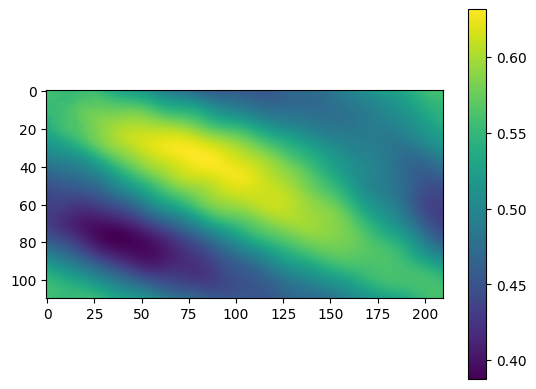

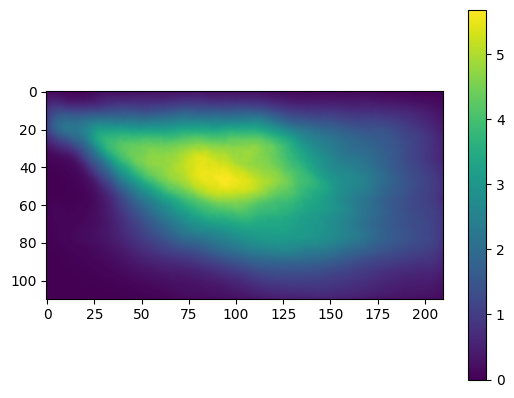

[12] time=13.87, avg_loss=0.8872, train_err=26.6162, 32_h1=0.8831, 32_l2=0.7810


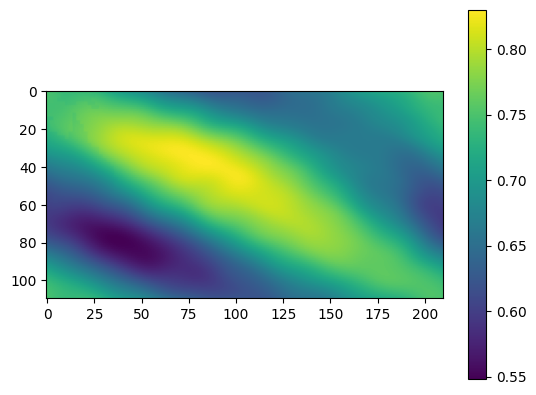

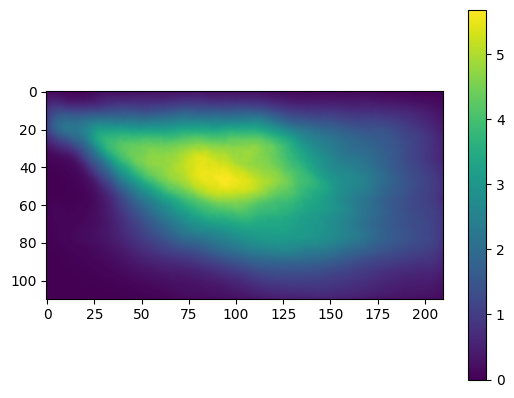

[13] time=14.03, avg_loss=0.8331, train_err=24.9934, 32_h1=0.8478, 32_l2=0.7092


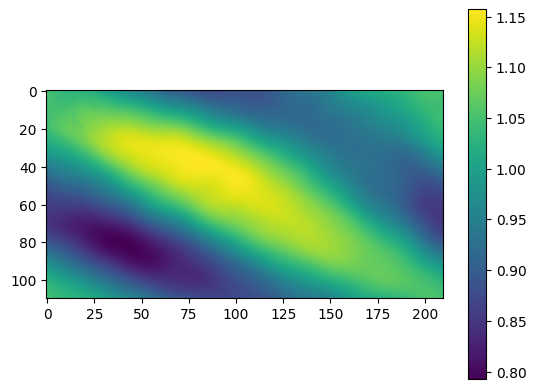

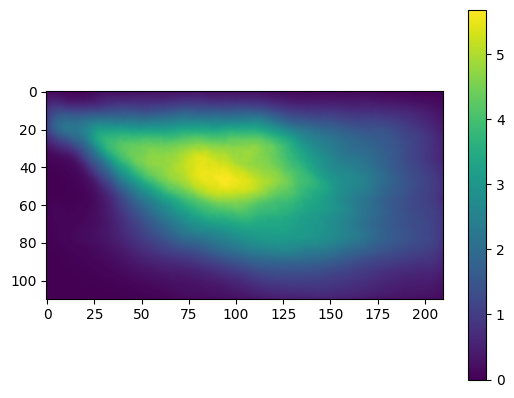

[14] time=13.87, avg_loss=0.7564, train_err=22.6917, 32_h1=0.8048, 32_l2=0.6215


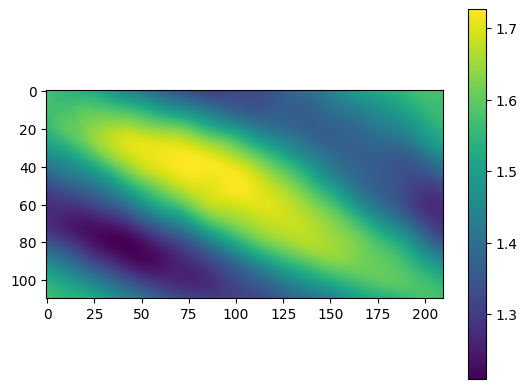

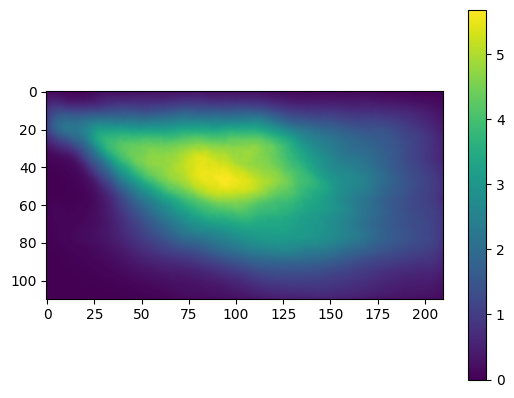

[15] time=13.96, avg_loss=0.6622, train_err=19.8659, 32_h1=0.7906, 32_l2=0.6141


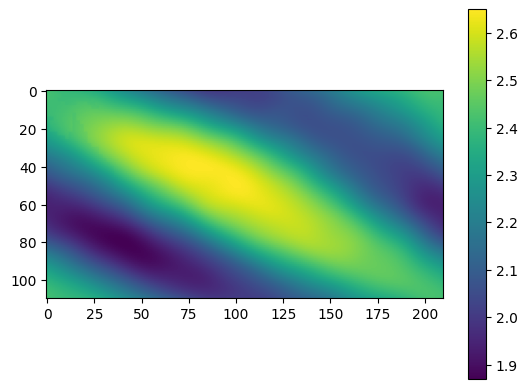

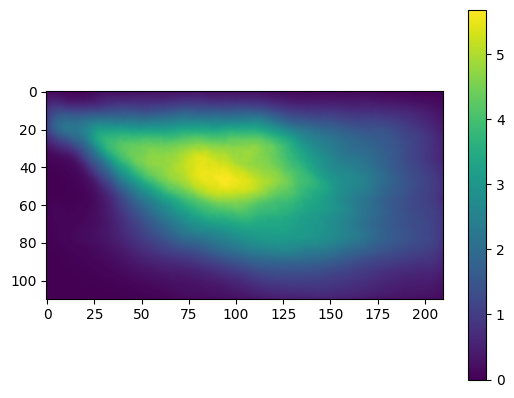

[16] time=14.16, avg_loss=0.6517, train_err=19.5521, 32_h1=0.7888, 32_l2=0.6463


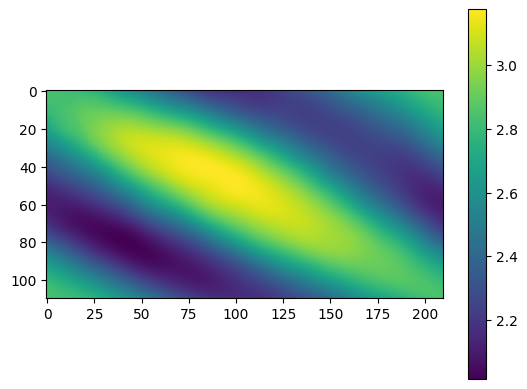

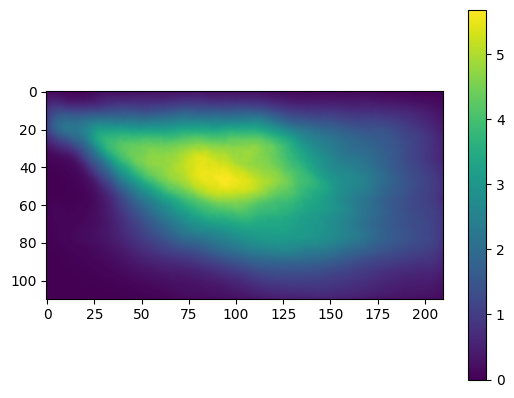

[17] time=14.04, avg_loss=0.6844, train_err=20.5313, 32_h1=0.7458, 32_l2=0.5731


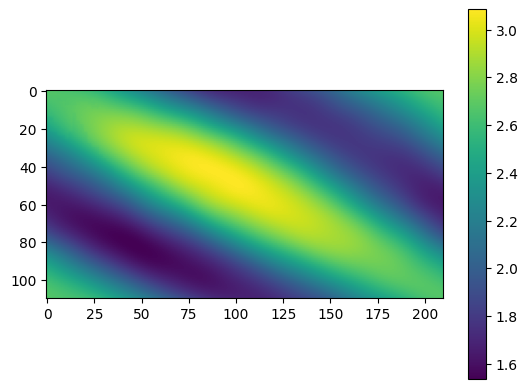

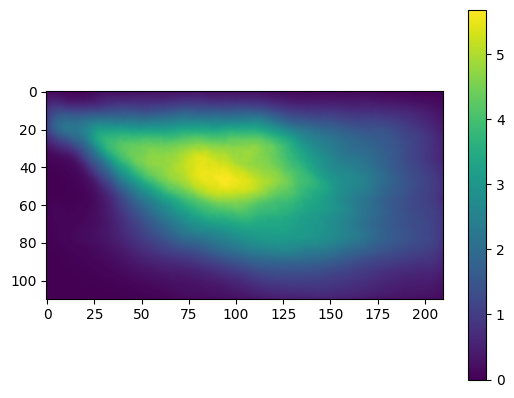

[18] time=14.01, avg_loss=0.6066, train_err=18.1973, 32_h1=0.7170, 32_l2=0.5255


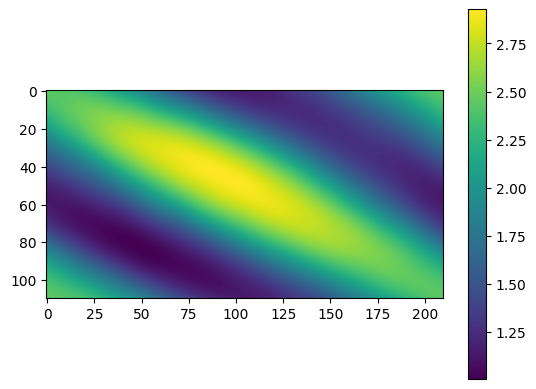

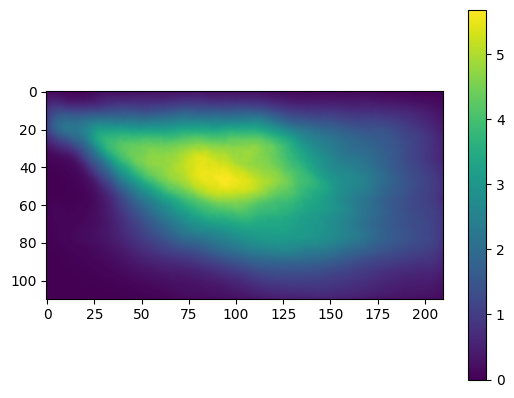

[19] time=13.98, avg_loss=0.5563, train_err=16.6902, 32_h1=0.7054, 32_l2=0.5153


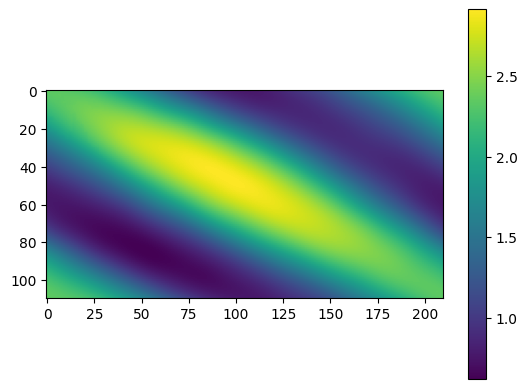

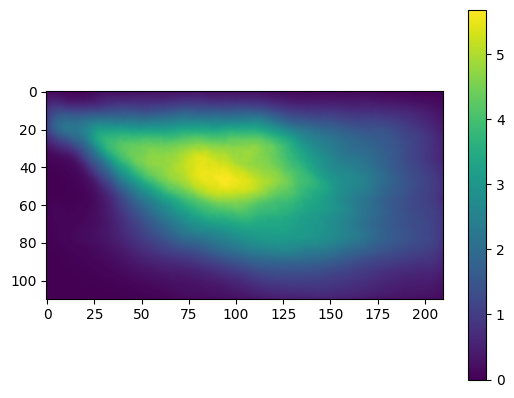

[20] time=14.16, avg_loss=0.5458, train_err=16.3744, 32_h1=0.6991, 32_l2=0.5117


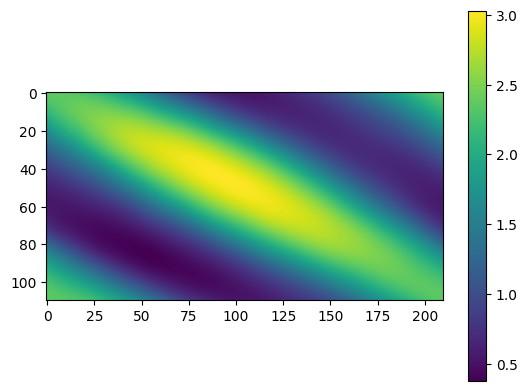

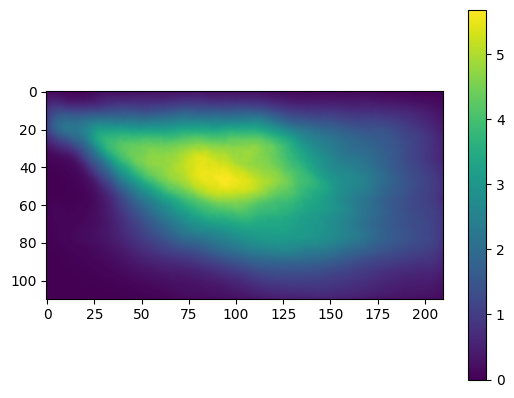

[21] time=13.95, avg_loss=0.5422, train_err=16.2658, 32_h1=0.6936, 32_l2=0.5045


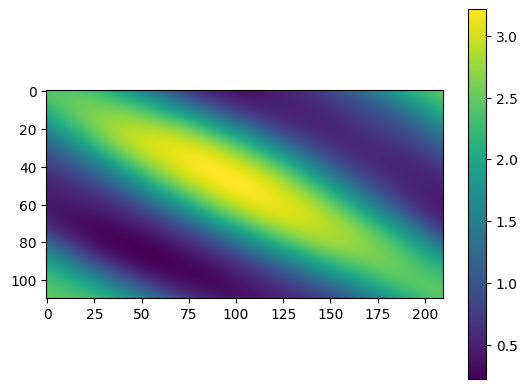

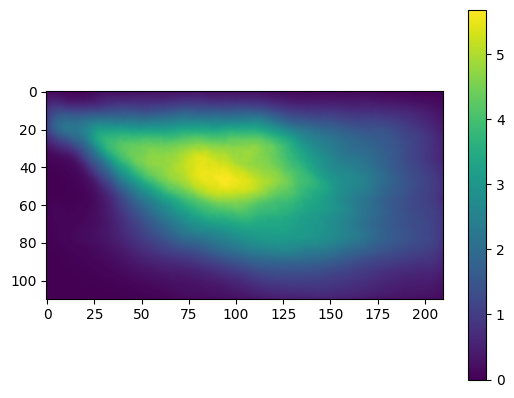

[22] time=13.95, avg_loss=0.5347, train_err=16.0404, 32_h1=0.6877, 32_l2=0.4937


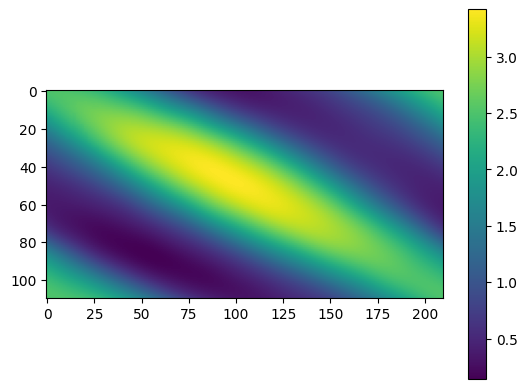

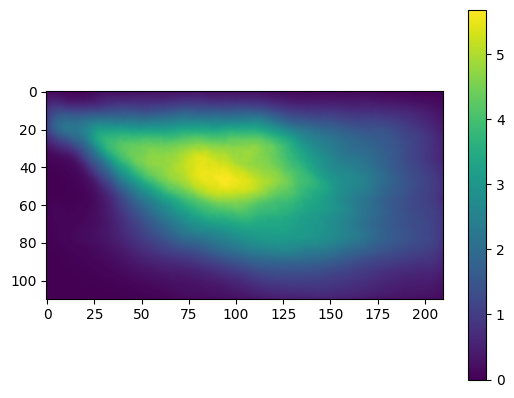

[23] time=14.00, avg_loss=0.5233, train_err=15.6989, 32_h1=0.6811, 32_l2=0.4813


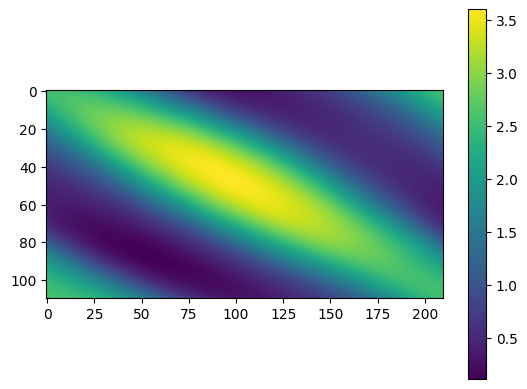

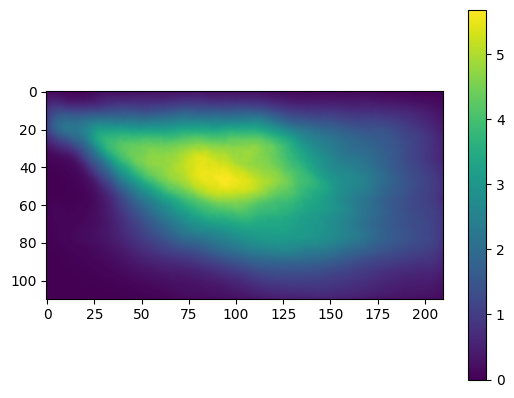

[24] time=13.91, avg_loss=0.5101, train_err=15.3039, 32_h1=0.6740, 32_l2=0.4691


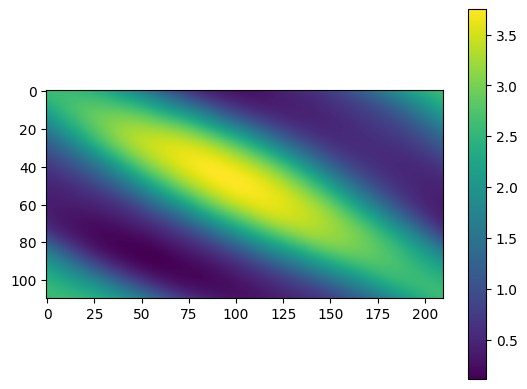

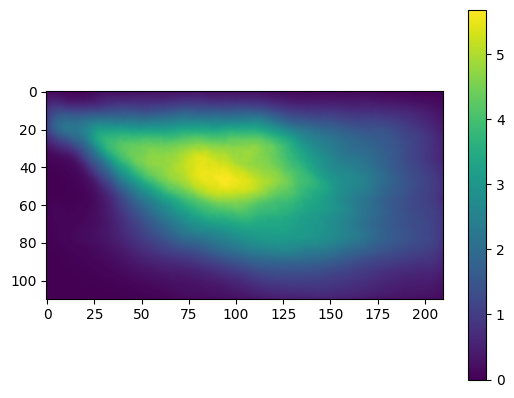

[25] time=13.89, avg_loss=0.4972, train_err=14.9146, 32_h1=0.6672, 32_l2=0.4586


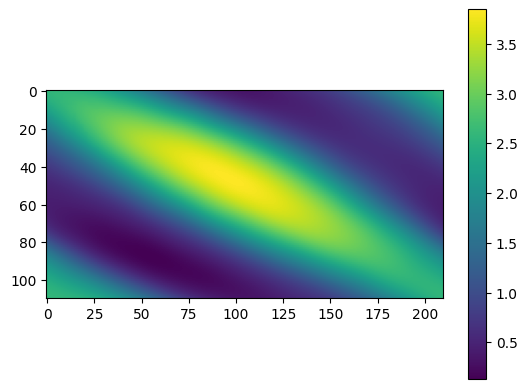

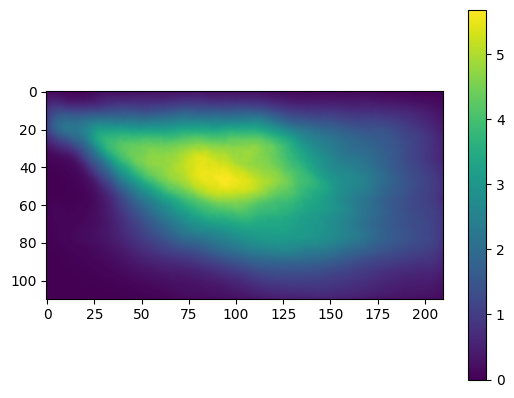

[26] time=13.96, avg_loss=0.4859, train_err=14.5770, 32_h1=0.6617, 32_l2=0.4507


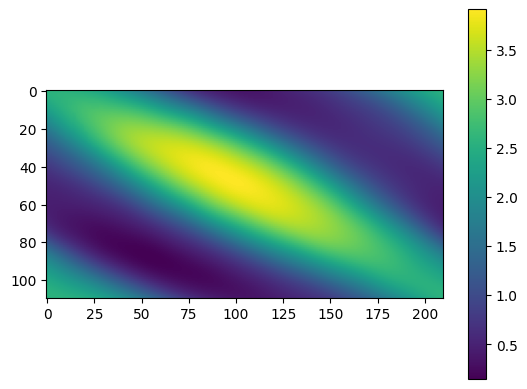

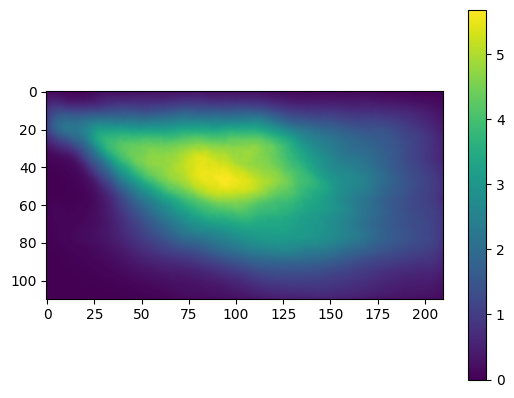

[27] time=14.06, avg_loss=0.4774, train_err=14.3208, 32_h1=0.6580, 32_l2=0.4457


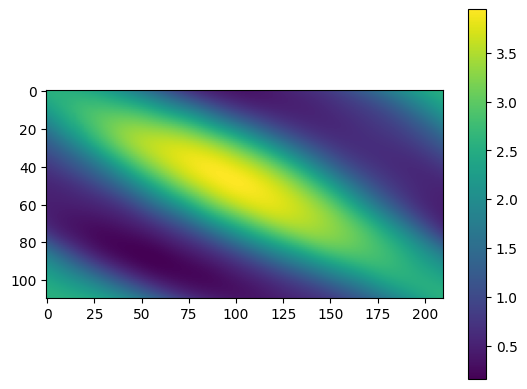

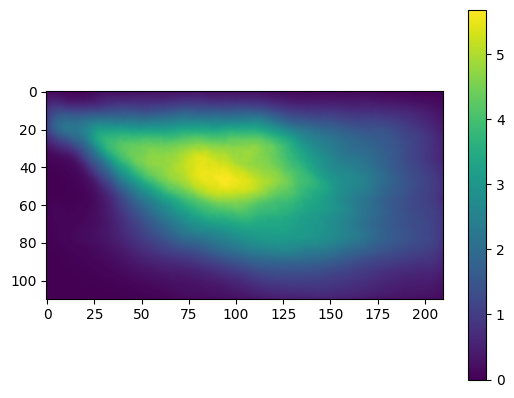

[28] time=13.90, avg_loss=0.4719, train_err=14.1563, 32_h1=0.6562, 32_l2=0.4432


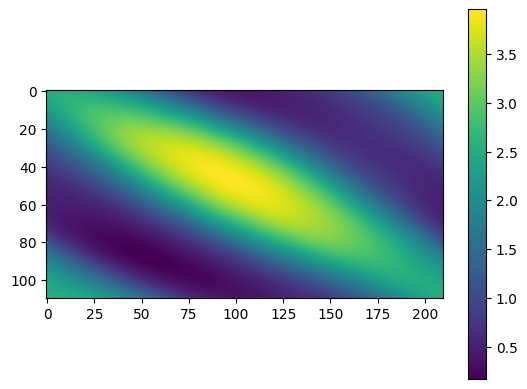

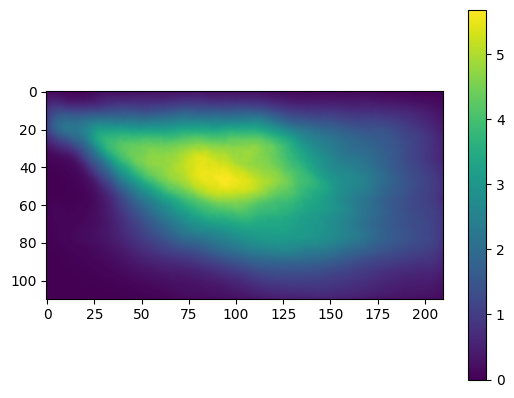

[29] time=13.88, avg_loss=0.4692, train_err=14.0753, 32_h1=0.6557, 32_l2=0.4425


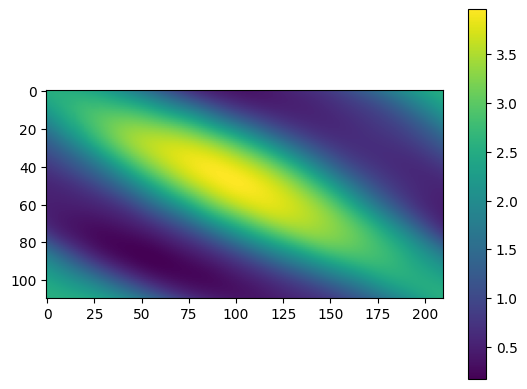

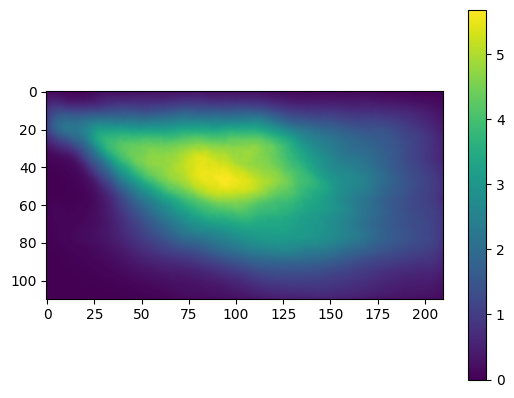

RuntimeError: Parent directory models does not exist.

In [31] used 48.0 MiB RAM in 620.59s (system mean cpu 21%, single max cpu 100%), peaked 3792.9 MiB above final usage, current RAM usage now 1488.2 MiB


In [31]:
train_fno(
        'FNO',
        '/users/ewinkelm/data/ewinkelm',
        MODEL_CONFIG,
        TRAINING_CONFIG
    )

In [5]:
a = {}

In [6]:
a.get(1, [])

[]

In [7]:
a.setdefault(1, []).append(2)

In [8]:
a

{1: [2]}

In [4]:
%imu_start
import h5py
import numpy as np
#
with h5py.File("/users/ewinkelm/data/ewinkelm/AllData_1725501397.4963796.hdf5", 'r+') as file:
    outputs = file['train_grids']
    outputs = np.array(outputs)[:,-1]
    geneses = file["train_genesis"]
    print(len(geneses))

80
In [4] used 2560.2 MiB RAM in 8.07s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 2651.1 MiB


In [11]:
import glob
import os

In [11] used 0.0 MiB RAM in 0.10s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 3441.5 MiB


In [12]:
indices = {}
n_samples = 0
file_paths = glob.glob(os.path.join("/users/ewinkelm/data/ewinkelm/", "*.hdf5"))

In [12] used 0.1 MiB RAM in 0.11s (system mean cpu 17%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 3441.6 MiB


In [5]:

file = h5py.File("/users/ewinkelm/data/ewinkelm/AllData_1725501397.5590131.hdf5", "r")
        

In [5] used 0.2 MiB RAM in 0.13s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 2651.3 MiB


In [10]:
geneses = np.array(file["train_genesis"])


In [10] used 10.9 MiB RAM in 0.13s (system mean cpu 18%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 2656.9 MiB


In [8]:
print(geneses.shape[0])

80
In [8] used 0.0 MiB RAM in 0.10s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 2652.0 MiB


In [11]:
outputs = file["train_grids"]
                

In [11] used -2537.8 MiB RAM in 0.11s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 119.0 MiB


In [12]:
outputs = outputs[:, -1]

In [12] used 253.9 MiB RAM in 0.55s (system mean cpu 19%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 372.9 MiB


In [13]:
outputs.shape

(80, 110, 210, 6, 6)

In [13] used 0.1 MiB RAM in 0.11s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 373.0 MiB
